In [1]:
from IPython.display import display, HTML

display(
    HTML(
        "<style>.jp-MarkdownCell { width: 80% !important; padding-left:10% !important; }</style>"
    )
)

# The unreasonable effectiveness and frustration of metadata in data-intensive analysis
### Deepak Cherian 
#### (NCAR / Climate and Global Dynamics Lab / Oceanography Section)

#### a.k.a Less data wrangling, more metadata handing
#### a.k.a From self-describing datasets to self-describing analyses


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Xarray

<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

Data always has attached metadata. Xarray lets you use metadata for your analysis.

Load an example dataset

In [3]:
import xarray as xr
xr.set_options(display_expand_attrs=False, display_expand_data=False)

ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes: (5)


At the very least we know the following
- I have a 3 dimensional array of air temperature values.
- The 3 dimensions have names: `time`, `lat`, `lon` in that order.
- I know the locations where I have data : a `lat`, `lon` **grid**
- I also know the timestamps at which I have data: a time **vector**


```{tip}
Climate datasets usually have metadata following the [Climate and Forecast Metadata Conventions (CF Conventions)](http://cfconventions.org/)
```

### Why Xarray? i.e. Why metadata?

Metadata provides context and provides code that is more legible. 

This reduces the likelihood of errors from typos and makes analysis more intuitive and fun!

If your code doesn't use metadata, **you** are carrying metadata in your head.

For example, consider this NumPy code (could easily be MATLAB code)

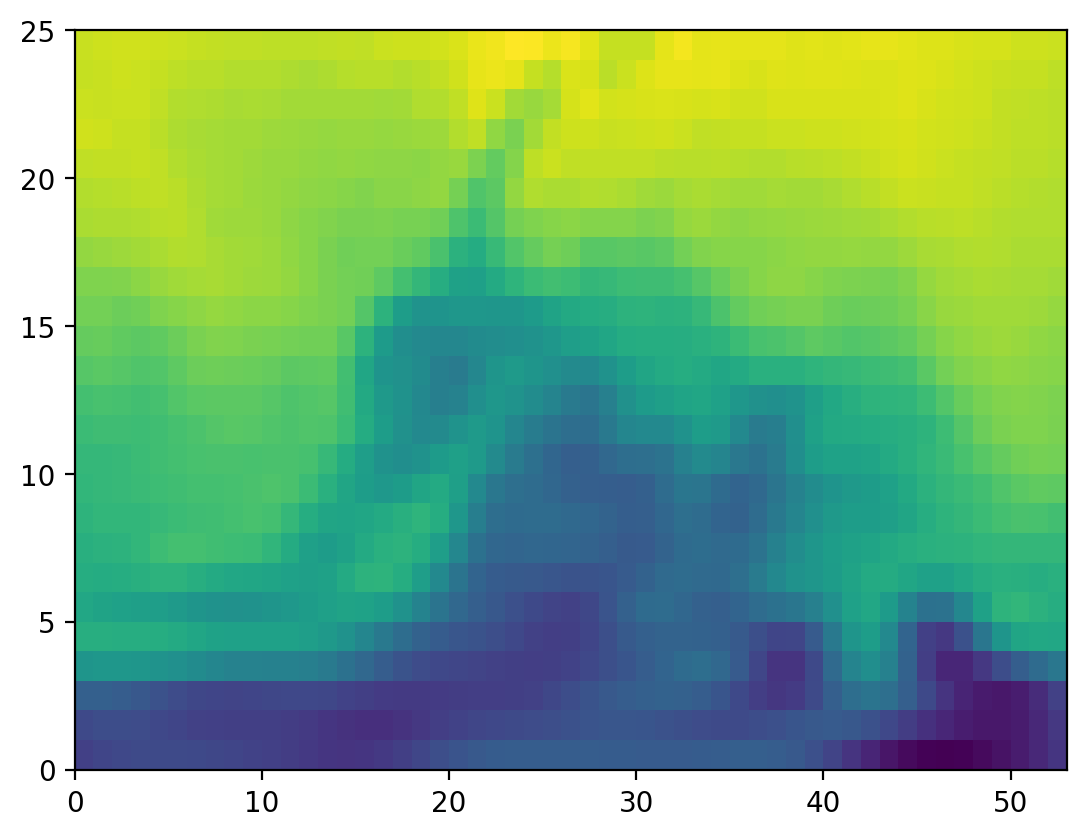

In [4]:
import matplotlib.pyplot as plt

lat = ds.air.lat.data  # numpy array
lon = ds.air.lon.data  # numpy array
temp = ds.air.data  # numpy array


plt.figure()

# plot the first timestep
#### What is this MAGIC constant `0` here.
#### I *could* infer that it is the time step 0.
#### What are the x and y axes?
plt.pcolormesh(temp[0, :, :]);

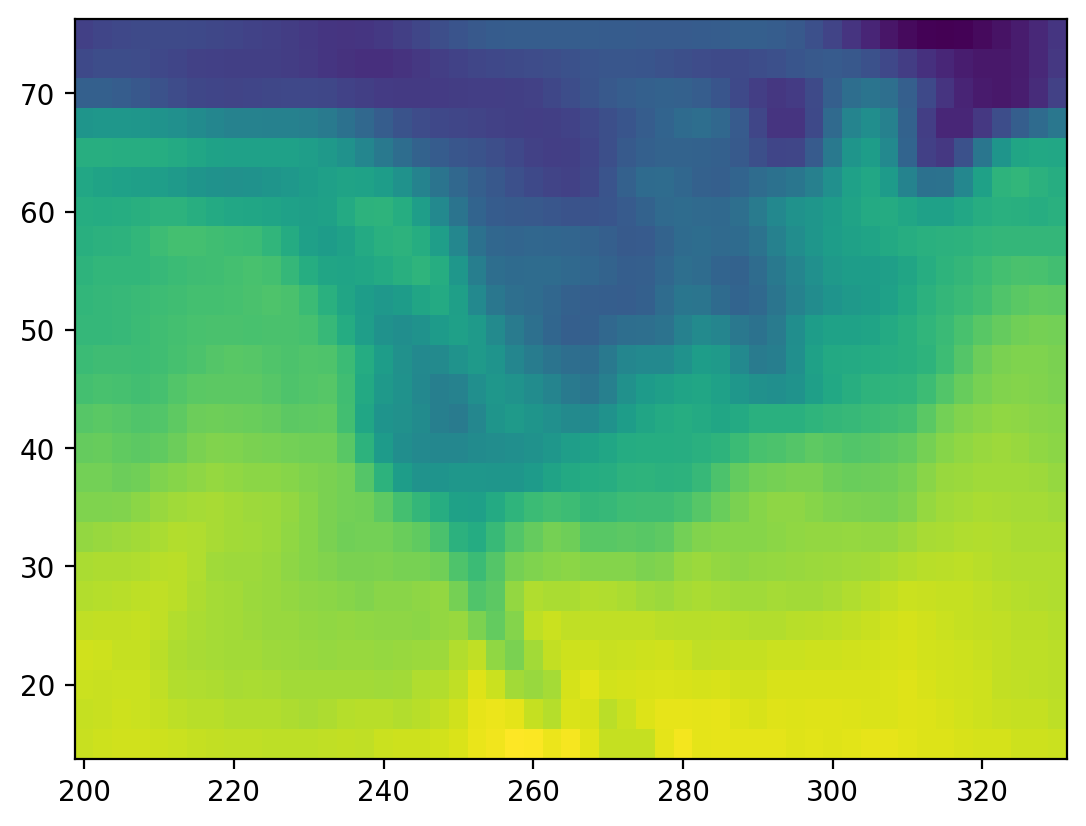

In [5]:
plt.figure()

#### What is this MAGIC constant `0` here.
#### I can guess that lon should be on the x axis
#### and lat should be the y axis
plt.pcolormesh(lon, lat, temp[0, :, :]);

### Now use xarray. 

We have
- Useful timestamp information in the title.
- Axes labeled with coordinate names and units
- A colorbar with a label describing the data, and units


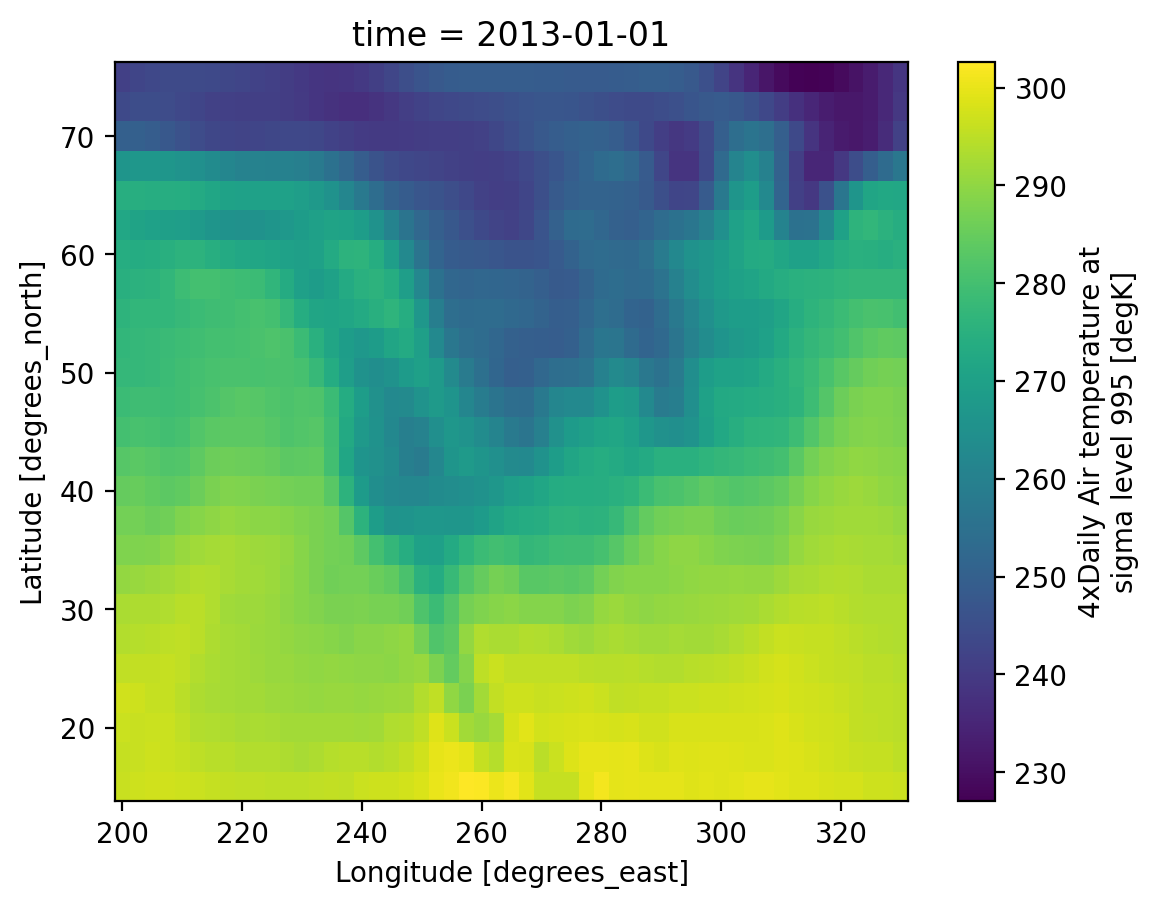

In [6]:
ds.air.isel(time=0).plot()

### More Xarray example

Use metadata to extract out data

In [7]:
# pull out data for all of 2013-May
ds.sel(time="2013-05")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 124, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-05-01 ... 2013-05-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 259.2 259.3 259.1 ... 298.2 297.6 297.5
Attributes: (5)

In [8]:
# demonstrate slicing
ds.sel(time=slice("2013-05", "2013-07"))

<xarray.Dataset>
Dimensions:  (lat: 25, time: 368, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-05-01 ... 2013-07-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 259.2 259.3 259.1 ... 299.4 299.5 299.7
Attributes: (5)

In [9]:
# demonstrate "nearest" indexing
ds.sel(lon=240.2, method="nearest")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
    lon      float32 240.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat) float32 239.6 237.2 240.1 249.0 ... 294.8 296.9 298.4
Attributes: (5)

## The wider context


- Increase in size and number of available datasets 
- Lots of effort aimed at handling increasing size:
  - easy parallelization in familiar idioms: `dask`



Each with its own nomenclature
- `lon` vs `LON` vs `Lon` vs `long` vs `longitude` vs `LONGITUDE`
- `Temp` vs `TEMP` vs `theta` vs `temp`


Step 0 of any analysis: “let’s first rename everything to my favourite names” a.k.a data wrangling a.k.a "what a waste of time"

## Can we do better? 


What if we can make greater use of CF metadata? (e.g. [Iris](https://scitools-iris.readthedocs.io/en/stable/index.html), and [MetPy](https://unidata.github.io/MetPy/latest/)).


```{tip}
Climate datasets usually have metadata following the [Climate and Forecast Metadata Conventions (CF Conventions)](http://cfconventions.org/)
```

<img src="https://cf-xarray.readthedocs.io/en/latest/_images/full-logo.png" align="center" width="50%">

[cf-xarray](https://cf-xarray.readthedocs.io/en/latest/) tries to fill this gap.


## Demo time: let's read some data!

These are test datasets uploaded to Github.

### Open a dataset

In [10]:
import pooch
import xarray as xr

mom6 = xr.open_dataset(
    pooch.retrieve('https://raw.githubusercontent.com/dcherian/cf-xarray-data/main/mom6.nc', 
    known_hash="a5d706d02e5d0be1e4ba9d9e8afb9bfd4120f6f19b1da5571bfa0e8d0a6a7668")
)
mom6

<xarray.Dataset>
Dimensions:      (time: 3, yh: 458, xq: 540, yq: 458, xh: 540, lath: 458,
                  latq: 458, lonh: 540, lonq: 540, nv: 2, scalar_axis: 1,
                  z_i: 35, z_l: 34)
Coordinates: (12/17)
    geolat       (yh, xh) float64 ...
    geolatb      (yq, xq) float64 ...
    geolon       (yh, xh) float64 ...
    geolonb      (yq, xq) float64 ...
  * time         (time) object 0001-01-16 12:00:00 ... 0001-03-16 12:00:00
  * xh           (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
    ...           ...
  * lonh         (lonh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * lonq         (lonq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * nv           (nv) float64 1.0 2.0
  * scalar_axis  (scalar_axis) float64 0.0
  * z_i          (z_i) float64 0.0 5.0 15.0 25.0 ... 5.25e+03 5.75e+03 6.25e+03
  * z_l          (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03
Data variables:
    taux         (time, yh, xq) float64 ...
    tauy         (time, yq, xh) float64 ...
Attributes: (5)

### use .cf to inspect metadata

```{tip} 
Get prettier output with the `rich` package and its Jupyter extension `%load_ext rich`
```

[Example here](https://cf-xarray.readthedocs.io/en/latest/faq.html)

In [11]:
%load_ext rich
import cf_xarray  # registers .cf

mom6.cf

╭─ Coordinates ────────────────────────────────────────────────────────────────────────────────────╮
│              CF Axes: * X: ['lonh', 'lonq', 'xh', 'xq']                                          │
│                       * Y: ['lath', 'latq', 'yh', 'yq']                                          │
│                       * Z: ['z_i', 'z_l']                                                        │
│                       * T: ['time']                                                              │
│                                                                                                  │
│       CF Coordinates: * longitude: ['lonh', 'lonq', 'xh', 'xq']                                  │
│                       * latitude: ['lath', 'latq', 'yh', 'yq']                                   │
│                       * vertical: ['z_i', 'z_l']                                                 │
│                       * time: ['time']                                                           │
│                                                                                                  │
│        Cell Measures:   area, volume: n/a                                                        │
│                                                                                                  │
│       Standard Names:   n/a                                                                      │
│                                                                                                  │
│               Bounds:   n/a                                                                      │
│                                                                                                  │
│        Grid Mappings:   n/a                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─ Data Variables ─────────────────────────────────────────────────────────────────────────────────╮
│        Cell Measures:   area, volume: n/a                                                        │
│                                                                                                  │
│       Standard Names:   surface_downward_x_stress: ['taux']                                      │
│                         surface_downward_y_stress: ['tauy']                                      │
│                                                                                                  │
│               Bounds:   n/a                                                                      │
│                                                                                                  │
│        Grid Mappings:   n/a                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

### Open a few more datasets

In [12]:

cm26 = xr.open_dataset(
    pooch.retrieve('https://raw.githubusercontent.com/dcherian/cf-xarray-data/main/cm26.nc', 
    known_hash="34a61d7586dc0527e2c44d571b72ebb36c5fb5e60bb09415cb43c49a10664eb6")
)
cm26

<xarray.Dataset>
Dimensions:         (time: 3, yu_ocean: 675, xu_ocean: 900, yt_ocean: 675,
                     xt_ocean: 900, nv: 2, st_edges_ocean: 51, st_ocean: 50,
                     sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/14)
    geolat_c        (yu_ocean, xu_ocean) float32 ...
    geolon_c        (yu_ocean, xu_ocean) float32 ...
  * time            (time) object 0181-01-16 12:00:00 ... 0181-03-16 12:00:00
  * xu_ocean        (xu_ocean) float64 -279.9 -279.5 -279.1 ... 78.9 79.3 79.7
  * yu_ocean        (yu_ocean) float64 -81.09 -80.92 -80.75 ... 89.54 89.7 89.87
    geolon_t        (yt_ocean, xt_ocean) float32 ...
    ...              ...
    geolat_t        (yt_ocean, xt_ocean) float32 ...
  * nv              (nv) float64 1.0 2.0
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean        (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean  (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean        (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
Data variables:
    tau_x           (time, yu_ocean, xu_ocean) float32 ...
    tau_y           (time, yu_ocean, xu_ocean) float32 ...
Attributes: (4)

## Why cf-xarray? MOAR metadata for analysis


Use "standard names" ([table](http://cfconventions.org/Data/cf-standard-names/80/build/cf-standard-name-table.html)) to extract variables.

In [13]:
# identical to mom6.cf["tau_y"]
wind_stress = mom6.cf["surface_downward_y_stress"]
wind_stress 

<xarray.DataArray 'tauy' (time: 3, yq: 458, xh: 540)>
[741960 values with dtype=float64]
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0001-03-16 12:00:00
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
  * yq       (yq) float64 -79.14 -79.01 -78.89 -78.76 ... 87.6 87.68 87.73 87.74
Attributes: (6)

In [14]:
# identical to cm26.cf["tauy"]
cm26.cf["surface_downward_y_stress"]

<xarray.DataArray 'tau_y' (time: 3, yu_ocean: 675, xu_ocean: 900)>
[1822500 values with dtype=float32]
Coordinates:
  * time      (time) object 0181-01-16 12:00:00 ... 0181-03-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.5 -279.1 -278.7 ... 78.9 79.3 79.7
  * yu_ocean  (yu_ocean) float64 -81.09 -80.92 -80.75 ... 89.54 89.7 89.87
    geolon_c  (yu_ocean, xu_ocean) float32 nan nan nan nan ... nan nan nan nan
    geolat_c  (yu_ocean, xu_ocean) float32 nan nan nan nan ... nan nan nan nan
Attributes: (6)

This is a major improvement! Previously I would have to rename all variables to my own standardized nomenclature.

### Use metadata to write code that generalizes *across* datasets

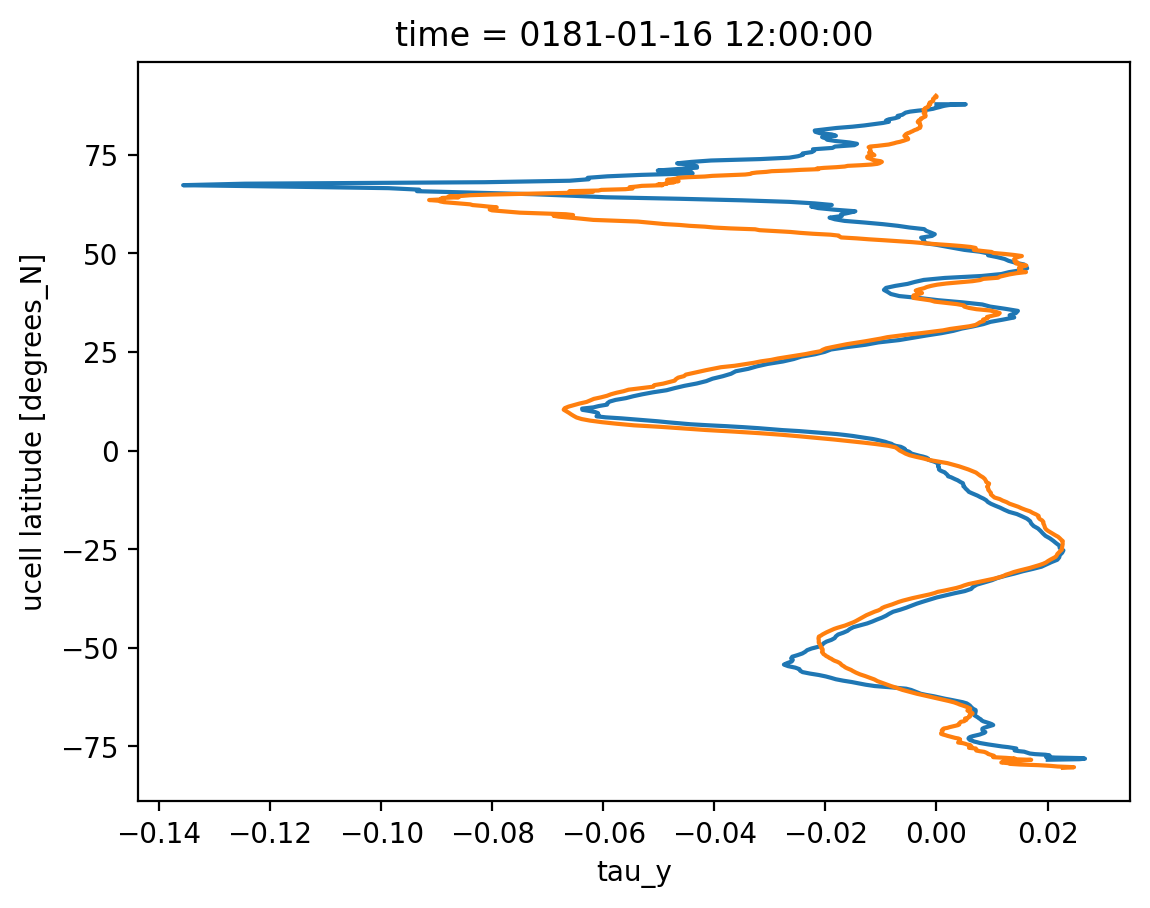

In [15]:
for ds in [mom6, cm26]:
    (
        # select meridional wind stress
        ds.cf["surface_downward_y_stress"]
        # select the first time instant
        .cf.isel(time=0)
        # mean along "X" or "longitude"
        .cf.mean(["X"])
        # automatically sets latitude as y-axis!
        .cf.plot()
    )

### Some other examples


Get the "X" vector

In [16]:
wind_stress.cf["X"]

<xarray.DataArray 'xh' (xh: 540)>
-286.7 -286.0 -285.3 -284.7 -284.0 -283.3 ... 69.33 70.0 70.67 71.33 72.0 72.67
Coordinates:
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
Attributes: (3)

Choose values by indexing along the "X" and "latitude" axes

In [17]:
wind_stress.cf.isel(X=-140, latitude=0)

<xarray.DataArray 'tauy' (time: 3)>
[3 values with dtype=float64]
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0001-03-16 12:00:00
    xh       float64 -20.0
    yq       float64 -79.14
Attributes: (6)

Apply xarray functions using "CF names" instead of dimension name

In [18]:
wind_stress.cf.mean(["X", "Y"])

<xarray.DataArray 'tauy' (time: 3)>
-0.009092 -0.008195 -0.004061
Coordinates:
  * time     (time) object 0001-01-16 12:00:00 ... 0001-03-16 12:00:00

## Frustrations

### Incomplete metadata is very common :(

- The number of data variables with standard names is low!
- Also lots of missing attributes
- Sometimes no attributes that apply to what you want to do.

### Dataset metadata optimizes for "self-describing" datasets.

That means some attributes can be redundant.

`xh` and `lonh` are both "nominal" longitudes while `geolon` is the true longitude location for a curvilinear grid.

For analysis purposes, We would like to unambiguously distinguish between "dimensions" and coordinate locations.

In [19]:
mom6.cf.axes

{'X': ['lonh', 'lonq', 'xh', 'xq'],
 'Y': ['lath', 'latq', 'yh', 'yq'],
 'Z': ['z_i', 'z_l'],
 'T': ['time']}

In [20]:
mom6.cf.coordinates

{'longitude': ['lonh', 'lonq', 'xh', 'xq'],
 'latitude': ['lath', 'latq', 'yh', 'yq'],
 'vertical': ['z_i', 'z_l'],
 'time': ['time']}

In [21]:
mom6

<xarray.Dataset>
Dimensions:      (time: 3, yh: 458, xq: 540, yq: 458, xh: 540, lath: 458,
                  latq: 458, lonh: 540, lonq: 540, nv: 2, scalar_axis: 1,
                  z_i: 35, z_l: 34)
Coordinates: (12/17)
    geolat       (yh, xh) float64 -79.2 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    geolatb      (yq, xq) float64 -79.14 -79.14 -79.14 ... 50.19 50.04 50.0
    geolon       (yh, xh) float64 -286.7 -286.0 -285.3 ... 72.97 72.98 73.0
    geolonb      (yq, xq) float64 -286.3 -285.7 -285.0 ... -287.0 -287.0 -287.0
  * time         (time) object 0001-01-16 12:00:00 ... 0001-03-16 12:00:00
  * xh           (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
    ...           ...
  * lonh         (lonh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * lonq         (lonq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * nv           (nv) float64 1.0 2.0
  * scalar_axis  (scalar_axis) float64 0.0
  * z_i          (z_i) float64 0.0 5.0 15.0 25.0 ... 5.25e+03 5.75e+03 6.25e+03
  * z_l          (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03
Data variables:
    taux         (time, yh, xq) float64 ...
    tauy         (time, yq, xh) float64 ...
Attributes: (5)

### "self-describing" can also result in VERY LONG standard names

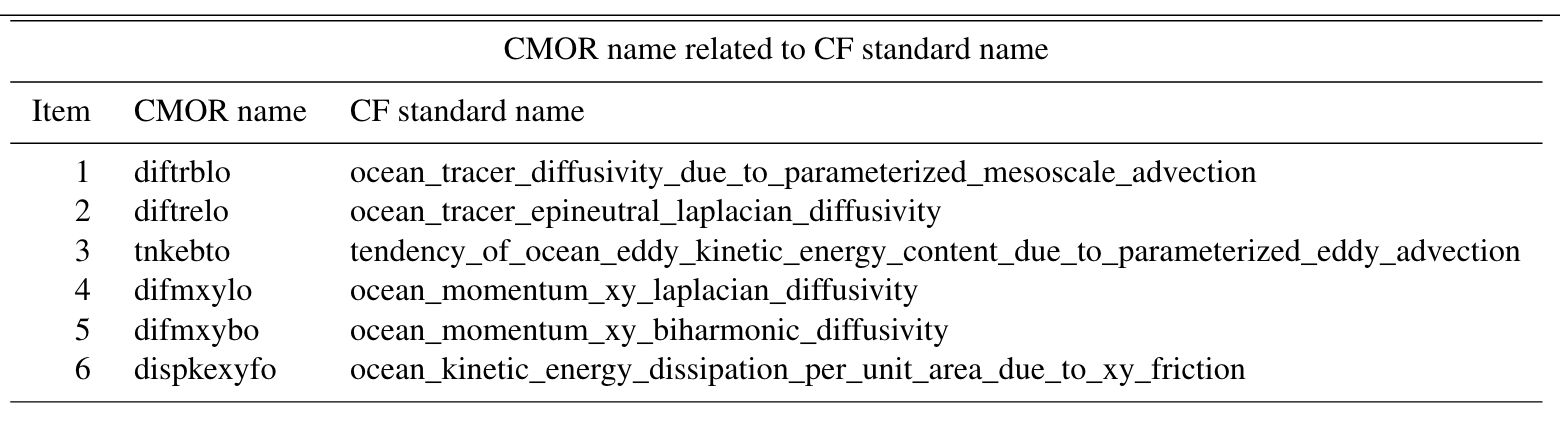

### And some times metadata is just wrong!

Let's inspect attributes: `degrees_east` vs `degree`! `degrees_east` is standards compliant

In [22]:
print(
    "xh: ", mom6.xh.attrs, 
    "\n\nlonh: ", mom6.lonh.attrs, 
    "\n\ngeolon: ", mom6.geolon.attrs
)

xh:  {'cartesian_axis': 'X', 'long_name': 'h point nominal longitude', 'units': 'degrees_east'} 

lonh:  {'cartesian_axis': 'X', 'long_name': 'Longitude', 'units': 'degrees_east'} 

geolon:  {'long_name': 'longitude at tracer (T) points', 'units': 'degree'}


## My story: Using metadata in practice

1. Read in datasets
2. Harmonize datasets by adding more attributes, standard names (making some up as needed)
3. Write as much generalized code as possible using cf_xarray.


### Example 1
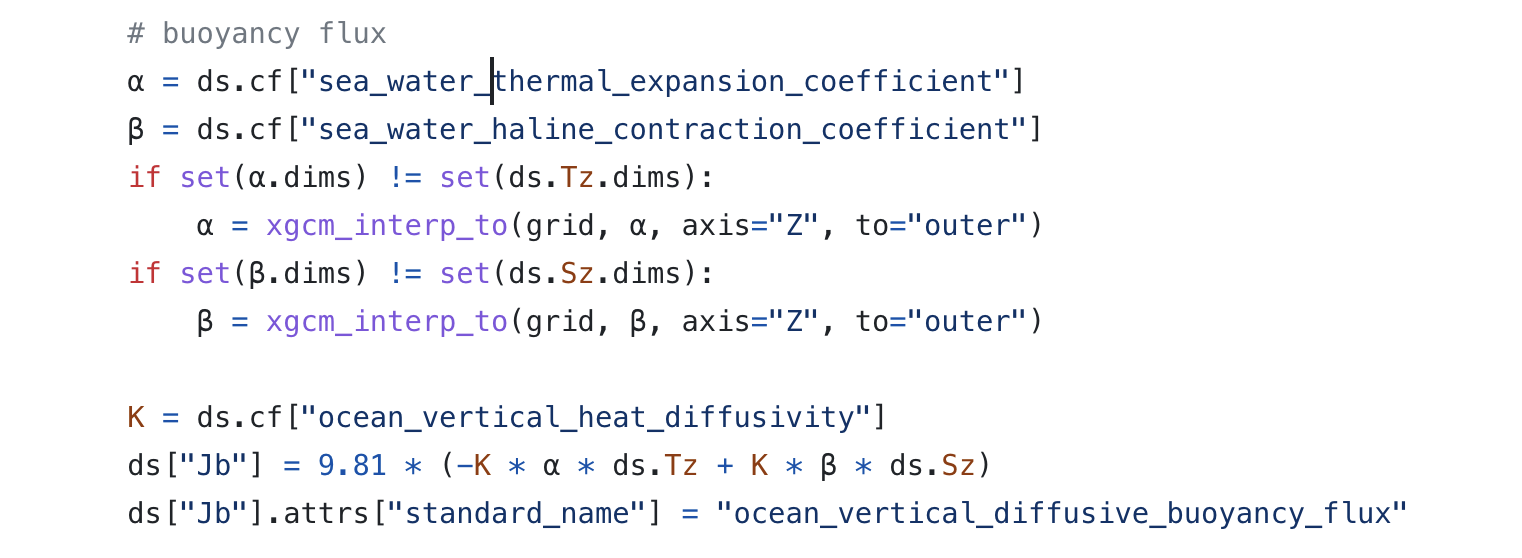


### Example 2 : error checking/validation

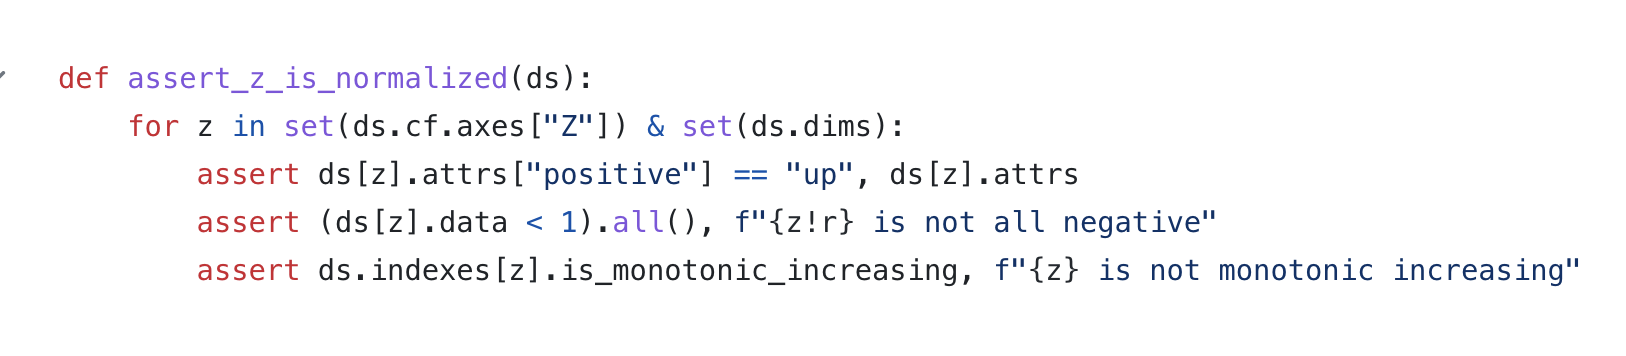

## Next

1. [cf-xarray quickstart](https://cf-xarray.readthedocs.io/en/latest/quickstart.html)
2. [how to use cf-xarray](https://cf-xarray.readthedocs.io/en/latest/howtouse.html)

In-depth examples:
1. [COSIMA ocean-sea ice demo](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Model_Agnostic_Analysis.html)
2. [CESM ocean model demo](https://pop-tools.readthedocs.io/en/latest/examples/cesm-cmip-cf-xarray.html)
3. [EarthCube demo](https://earthcube2021.github.io/ec21_book/notebooks/ec21_cherian_etal/DC_01_cf-xarray.html)